In [1]:
import sys
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts")  
import analyseVCF as aVCF
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import venn as vn
import displayPete as prf
import copy

<h3> Load VCFs and Prepare DF

In [2]:
## LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/truthset/"
BED_FILE_NAME = "union13callableMQonlymerged_addcert_nouncert_excludesimplerep_excludesegdups_excludedecoy_excludeRepSeqSTRs_noCNVs_v2.19_2mindatasets_5minYesNoRatio.bed"
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
bed.reverse()
truthBed = copy.deepcopy(bed)

reading BED file. . .



In [3]:
## LOAD TRUTH SET VCF
sampleNamesTruth = {'NA12878':'70-30truth'}
PathTruth = "/Users/peterpriestley/hmf/analyses/70-30sample/truthset/"
VCFFileTruth = "na12878-na24385-somatic-truth.vcf"
dfTruth = aVCF.loadVaraintsFromVCF(PathTruth,VCFFileTruth,sampleNamesTruth,True,truthBed)
dfTruth['chromPos']=dfTruth['chrom']+':'+dfTruth['pos']

reading vcf file. . .

reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
data frame loaded



In [5]:
## LOAD VCF
#sampleNames = {'/sample/output/GIAB_SOMATIC-MIX/somaticVariants/CPCT11111111R_CPCT11111111T/CPCT11111111R_CPCT11111111T_merged_somatics_snpEff_dbSNP_Cosmicv76' \
#                    :'melted'}
#VCFFileSample = "CPCT11111111R_CPCT11111111T_merged_somatics_snpEff_dbSNP_Cosmicv76_melted.vcf" 
sampleNames = {'CPCT11111111T.mutect':'mutect', \
               'CPCT11111111T.freebayes':'freebayes', \
               'TUMOR.strelka':'strelka', \
               'TUMOR.varscan':'varscan'}
PathSample = "/Users/peterpriestley/hmf/analyses/70-30sample/160524/"
VCFFileSample = "CPCT11111111R_CPCT11111111T_merged_somatics.vcf"
df = aVCF.loadVaraintsFromVCF(PathSample,VCFFileSample,sampleNames,True,bed)

reading vcf file. . .

reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
reading VCF File line: 1100000
reading VCF File line: 1200000
reading VCF File line: 1300000
data frame loaded



In [125]:
# create Additional Fields
df['chromPos']=df['chrom']+':'+df['pos']
df['Truth']=df.chromPos.isin(dfTruth['chromPos'])
## FIX IN VCF 
df['numCallers']= df['vennSegment'].apply(lambda x: x.count('-')+1)
df['numCallers'][df['vennSegment'] == 'Intersection'] = 4
df[df['vennSegment'] == 'strelka-filterInvarscan-freebayes'].head()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,chrom,pos,chromFrac,caller,ref,alleleTumor1,alleleTumor2,vennSegment,variantType,variantSubType,allelicFreq,chromPos,Truth,callerVenn,numCallers
1031522,1,28172515,1.113029,strelka,A,A,G,strelka-filterInvarscan-freebayes,SNP,,0.481481,1:28172515,True,strelka:strelka-filterInvarscan-freebayes,3
1031523,1,28172515,1.113029,varscan,A,A,G,strelka-filterInvarscan-freebayes,SNP,,0.235300,1:28172515,True,varscan:strelka-filterInvarscan-freebayes,3
1031524,1,28172515,1.113029,freebayes,A,A,G,strelka-filterInvarscan-freebayes,SNP,,0.202899,1:28172515,True,freebayes:strelka-filterInvarscan-freebayes,3
1274497,2,42235998,2.173668,strelka,C,C,T,strelka-filterInvarscan-freebayes,SNP,,0.473684,2:42235998,True,strelka:strelka-filterInvarscan-freebayes,3
1274498,2,42235998,2.173668,varscan,C,C,T,strelka-filterInvarscan-freebayes,SNP,,0.187500,2:42235998,True,varscan:strelka-filterInvarscan-freebayes,3


<h3> High Level Stats

In [132]:
df[['caller','variantType','pos']].groupby(['variantType','caller']).agg('count')

pos
variantType caller            
INDEL       70-30truth   78123
            freebayes     8448
            strelka      21389
            varscan      53028
SNP         70-30truth  927356
            freebayes   144817
            mutect      868551
            strelka     889453
            varscan     790073

<h3> Overlapping Analysis

In [ ]:
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)

In [ ]:
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['varscan1','freebayes','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()

<h3> SNP Venn

In [20]:
snpdf = df[(df.variantType != 'SNP')]

In [21]:
pd.pivot_table(snpdf, values='pos', index=['vennSegment'], columns=['Truth','caller'], aggfunc='count')

Truth                                 False                      True   \
caller                            freebayes strelka varscan 70-30truth   
vennSegment                                                              
                                        NaN     NaN     NaN    78123.0   
filterInvarscan-freebayes               3.0     NaN     3.0        NaN   
freebayes                             682.0     NaN     NaN        NaN   
strelka                                 NaN   166.0     NaN        NaN   
strelka-filterInvarscan                 NaN     1.0     1.0        NaN   
strelka-filterInvarscan-freebayes       NaN     NaN     NaN        NaN   
strelka-freebayes                      22.0    22.0     NaN        NaN   
strelka-varscan                         NaN   114.0   114.0        NaN   
strelka-varscan-freebayes              23.0    23.0    23.0        NaN   
varscan                                 NaN     NaN  2048.0        NaN   
varscan-freebayes                      28.0     NaN    28.0        NaN   

Truth                                                          
caller                            freebayes  strelka  varscan  
vennSegment                                                    
                                        NaN      NaN      NaN  
filterInvarscan-freebayes               2.0      NaN      2.0  
freebayes                             924.0      NaN      NaN  
strelka                                 NaN   1737.0      NaN  
strelka-filterInvarscan                 NaN     23.0     23.0  
strelka-filterInvarscan-freebayes       4.0      4.0      4.0  
strelka-freebayes                     662.0    662.0      NaN  
strelka-varscan                         NaN  13199.0  13199.0  
strelka-varscan-freebayes            5438.0   5438.0   5438.0  
varscan                                 NaN      NaN  31485.0  
varscan-freebayes                     660.0      NaN    660.0

In [ ]:
vn.venn([snpdf[snpdf.caller == 'mutect']['chromPos'], \
         snpdf[snpdf.caller == 'strelka']['chromPos'], \
        snpdf[snpdf.caller == 'varscan']['chromPos'], \
        snpdf[snpdf.caller == 'freebayes']['chromPos'] \
        ],['mutect','strelka','varscan','freebayes'],figsize=(15,10))

### <hd1> Indel Venn

In [135]:
indeldf= df[(df.variantType == 'INDEL')]

In [ ]:
pd.pivot_table(snpdf, values='pos', index=['vennSegment'], columns=['Truth','caller'], aggfunc='count')

In [ ]:
vn.venn([indeldf[indeldf.caller == 'strelka']['chromPos'], \
        indeldf[indeldf.caller == 'varscan']['chromPos'], \
        indeldf[indeldf.caller == 'freebayes']['chromPos'] \
        ],['strelka','varscan','freebayes'],figsize=(15,10))

<h3> Allelic Depth

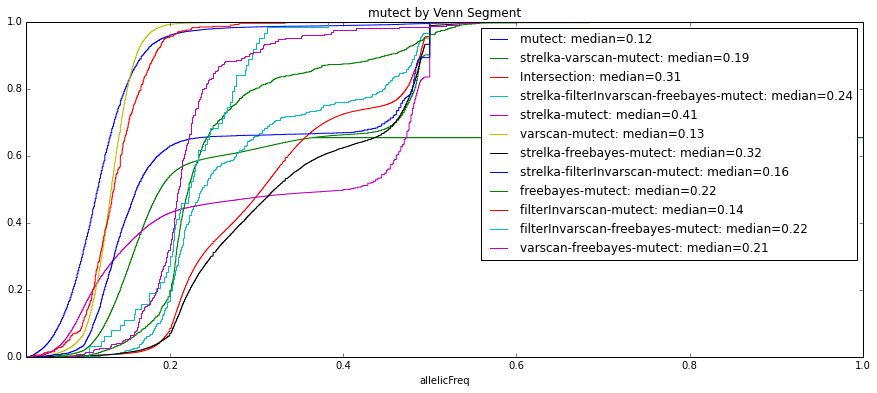

In [143]:
# BY CALLER BY VENN SEGMENT - Single Caller
myCaller = 'mutect'
vennSegments = df[df.caller == myCaller].vennSegment.unique()
for vennSegment in vennSegments:
    ser = df[df.vennSegment == vennSegment].allelicFreq
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": median="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" by Venn Segment",figsize=[15,6])

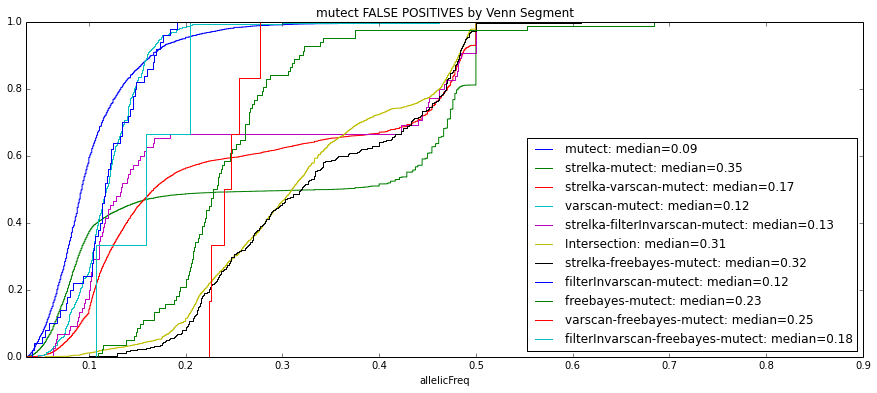

In [144]:
# BY CALLER BY VENN SEGMENT - Single Caller FALSE POSITIVES
vennSegments = df[(df.caller == myCaller) & (df.Truth == False) ].vennSegment.unique()
for vennSegment in vennSegments:
    ser = df[(df.vennSegment == vennSegment) & (df.Truth == False)].allelicFreq
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": median="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FALSE POSITIVES by Venn Segment",figsize=[15,6])

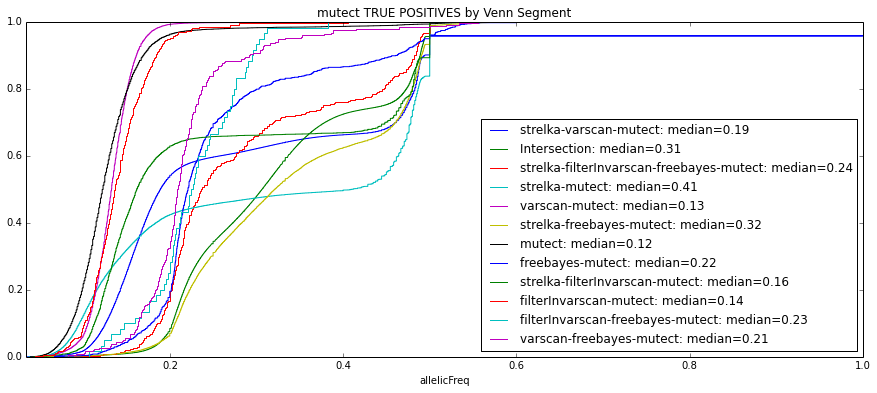

In [145]:
# BY CALLER BY VENN SEGMENT - Single Caller TRUE POSITIVES
vennSegments = df[(df.caller == myCaller) & (df.Truth == True) ].vennSegment.unique()
for vennSegment in vennSegments:
    ser = df[(df.vennSegment == vennSegment) & (df.Truth == True)].allelicFreq
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": median="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" TRUE POSITIVES by Venn Segment",figsize=[15,6])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
#plt.scatter(df[df.caller == 'mutect'].chromFrac, df[df.caller == 'mutect'].allelicFreq, s=10, c='b', marker="s")